## Weight and Biases 
- 머신러닝 실험을 원활히 지원하기 위한 상용도구
- 협업, code versioning, 실험 결과 기록 제공
- MLOps의 대표적인 툴로 확대중...

In [ ]:
!pip install wandb -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 11.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 3.2 MB/s eta 0:00:00


In [ ]:
import wandb
wandb.init(project="AI_tech project", entity='imsmile2000')


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
import torch
import torchvision
from torchvision import datasets, models, transforms

import torch.nn as nn
import torch.optim as optim
import os


import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

## print out the pytorch version used (1.31 at the time of this tutorial)
print(torch.__version__)

1.13.1+cu116


In [ ]:
# ant 와 bee 구분하는 dataset
DATA_PATH = "https://download.pytorch.org/tutorial/hymenoptera_data.zip"

In [ ]:
import urllib
import os
import shutil
from zipfile import ZipFile

urllib.request .urlretrieve(DATA_PATH, "hymenoptera_data.zip")

with ZipFile("hymenoptera_data.zip", 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall()


In [ ]:
## configure root folder on your gdrive
data_dir = "./hymenoptera_data"

## custom transformer to flatten the image tensors
class ReshapeTransform:
    def __init__(self, new_size):
        self.new_size = new_size

    def __call__(self, img):
        result = torch.reshape(img, self.new_size)
        return result

## transformations used to standardize and normalize the datasets
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor()
    ]),
    'val': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor()
    ]),
}

## load the correspoding folders
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

## load the entire dataset; we are not using minibatches here
train_dataset = torch.utils.data.DataLoader(image_datasets['train'],
                                            batch_size=len(image_datasets['train']),
                                            shuffle=True)

In [ ]:
class MyCNNModel(nn.Module):
    def __init__(self):
        super(MyCNNModel, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=0),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.drop_out = nn.Dropout()
        self.fc1 = nn.Linear(3 * 3 * 64, 1000)
        self.fc2 = nn.Linear(1000, 1)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)

        out = out.view(out.size(0), -1)
        out = self.drop_out(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [ ]:
EPOCHS = 100
BATCH_SIZE = 64
LEARNING_RATE = 0.01

In [ ]:

model = MyCNNModel()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)


In [ ]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [ ]:
EPOCHS = 50
BATCH_SIZE = 64
LEARNING_RATE = 0.001

config={"epochs": EPOCHS, "batch_size": BATCH_SIZE, "learning_rate" : LEARNING_RATE}

In [ ]:
# config
wandb.init(project="AI_tech project", config=config)
# wandb.config.batch_size = BATCH_SIZE
# wandb.config.learning_rate = LEARNING_RATE
# config={"epochs": EPOCHS, "batch_size": BATCH_SIZE, "learning_rate" : LEARNING_RATE}

for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_dataset:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device).type(torch.cuda.FloatTensor)
        optimizer.zero_grad()        
        y_pred = model(X_batch)
               
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        acc = binary_acc(y_pred, y_batch.unsqueeze(1))
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
        
    train_loss = epoch_loss/len(train_dataset)
    train_acc = epoch_acc/len(train_dataset)
    print(f'Epoch {e+0:03}: | Loss: {train_loss:.5f} | Acc: {train_acc:.3f}')
    wandb.log({'accuracy': train_acc, 'loss': train_loss})


accuracy,▁▃▁▂▃▃▃▄▃▃▃▄▃▄▄▄▅▄▅▄▅▅▆▅▅▆▅▇▆▆▇▆▆▇▆▇▇███
loss,█▇██▇▆▇▆▇▆▇▆▆▅▅▅▅▅▄▄▄▄▃▄▃▄▄▂▃▂▂▃▃▂▂▂▂▁▁▁
accuracy,95.0
loss,0.13276


Epoch 001: | Loss: 0.14737 | Acc: 93.000
Epoch 002: | Loss: 0.13325 | Acc: 95.000
Epoch 003: | Loss: 0.16783 | Acc: 93.000
Epoch 004: | Loss: 0.13956 | Acc: 94.000
Epoch 005: | Loss: 0.14058 | Acc: 94.000
Epoch 006: | Loss: 0.14883 | Acc: 94.000
Epoch 007: | Loss: 0.09366 | Acc: 97.000
Epoch 008: | Loss: 0.11774 | Acc: 95.000
Epoch 009: | Loss: 0.12828 | Acc: 95.000
Epoch 010: | Loss: 0.11283 | Acc: 96.000
Epoch 011: | Loss: 0.08465 | Acc: 98.000
Epoch 012: | Loss: 0.11546 | Acc: 95.000
Epoch 013: | Loss: 0.14492 | Acc: 95.000
Epoch 014: | Loss: 0.09828 | Acc: 95.000
Epoch 015: | Loss: 0.12189 | Acc: 96.000
Epoch 016: | Loss: 0.06591 | Acc: 97.000
Epoch 017: | Loss: 0.11373 | Acc: 95.000
Epoch 018: | Loss: 0.08260 | Acc: 96.000
Epoch 019: | Loss: 0.12510 | Acc: 95.000
Epoch 020: | Loss: 0.09173 | Acc: 97.000
Epoch 021: | Loss: 0.04818 | Acc: 98.000
Epoch 022: | Loss: 0.07868 | Acc: 97.000
Epoch 023: | Loss: 0.06613 | Acc: 97.000
Epoch 024: | Loss: 0.09503 | Acc: 97.000
Epoch 025: | Los

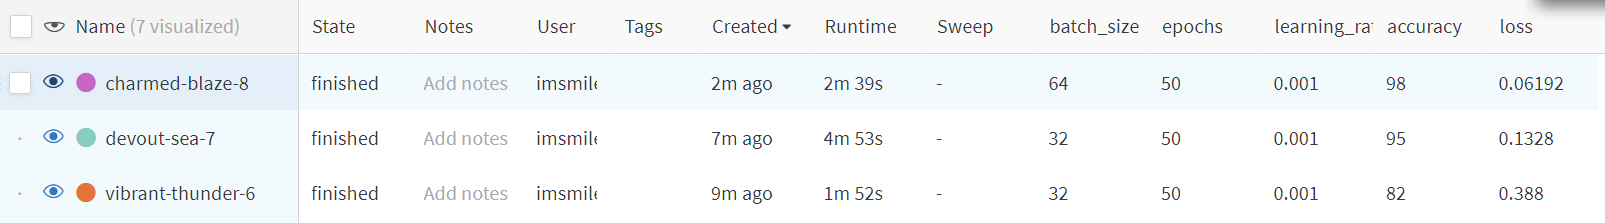

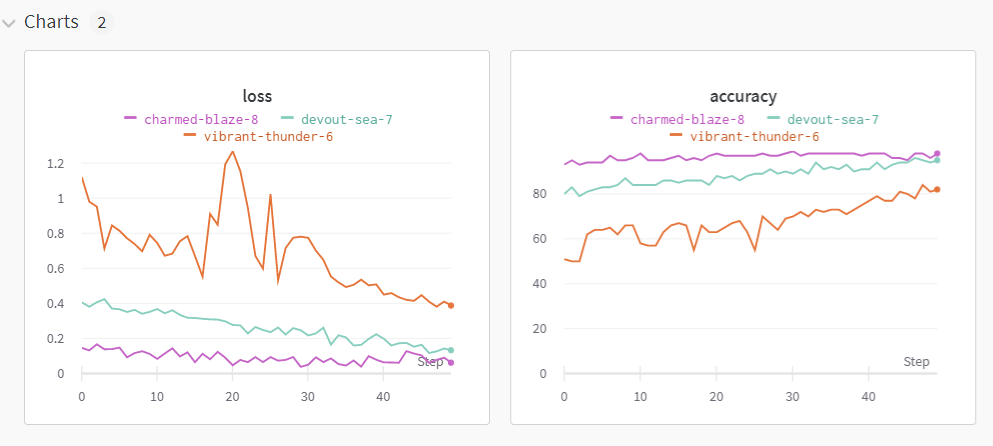

## 회고
- wandb에 가입하고 colab에서 진행되는 실험에 대한 결과를 wandb에서 확인할 수 있다는 점이 굉장히 흥미로웠다. wandb에 더 익숙해지는 시간이 필요할 것 같다.